# Domain coloring - Visualizing complex functions

In [2]:
import os
import sys
import numpy as np
from scipy.interpolate import interp2d

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import hsv_to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# Various size parameters for plotting
axistitlesize = 25
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

In [4]:
out = './output/'

In [5]:
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

## Domain coloring basics

In [14]:
def create_domain(xy, N):
    """
    Create coordinate system for an arbitrary complex domain,
    """
    X = np.linspace(-xy, xy, N)
    Y = np.linspace(-xy, xy, N)
    X, Y = np.meshgrid(X, Y)
    
    return X + 1j*Y[::-1]

def normalize(arr):
    """
    Normalize data based on their min/max values.
    """
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

def corr_singular(z):
    """
    Handle singular expressions
    """
    r = np.finfo(np.float64).eps
    return np.nan_to_num(z, nan=r, neginf=None, posinf=None)

### Define complex functions

In [31]:
# Basic functions
f_p2 = lambda z : z**2
f_p3 = lambda z : z**3
f_p5m1 = lambda z : z**5 - 1
f_log = lambda z : np.log(z)
f_sin = lambda z : np.sin(z)
f_sinz = lambda z : np.sin(1/z)

# Functions that look interesting
f_nice_1 = lambda z : (z**2 - 1j) / (2*z**2 + 2j)
f_nice_2 = lambda z : (z - 2)**2 * (z + 1 - 2j) * (z + 2 - 2j) / z**3
f_nice_3 = lambda z : ((z**2 - 1) * (z - 2 - 1j)**2) / (z**2 + 2 + 2j)

### Calculate function on an arbitrary domain

In [52]:
# Create domain for plot
z = create_domain(xy=1, N=2000)
# Calculate function values
zz = f_sinz(z)
# Correct singularities (if exist)
zz = corr_singular(zz)

<ipython-input-31-13a343e2693f>:7: RuntimeWarning: overflow encountered in sin
  f_sinz = lambda z : np.sin(1/z)


In [53]:
# Length of z
r = corr_singular(np.abs(zz))
# Argument of z
arg = normalize(np.angle(zz) % (2 * np.pi))
# Create logarithmic mask of z
mask = normalize(np.log2(r) % 1)

<ipython-input-53-f7ea5a1d8d1d>:2: RuntimeWarning: overflow encountered in absolute
  r = corr_singular(np.abs(zz))


### Plot components and final masked image

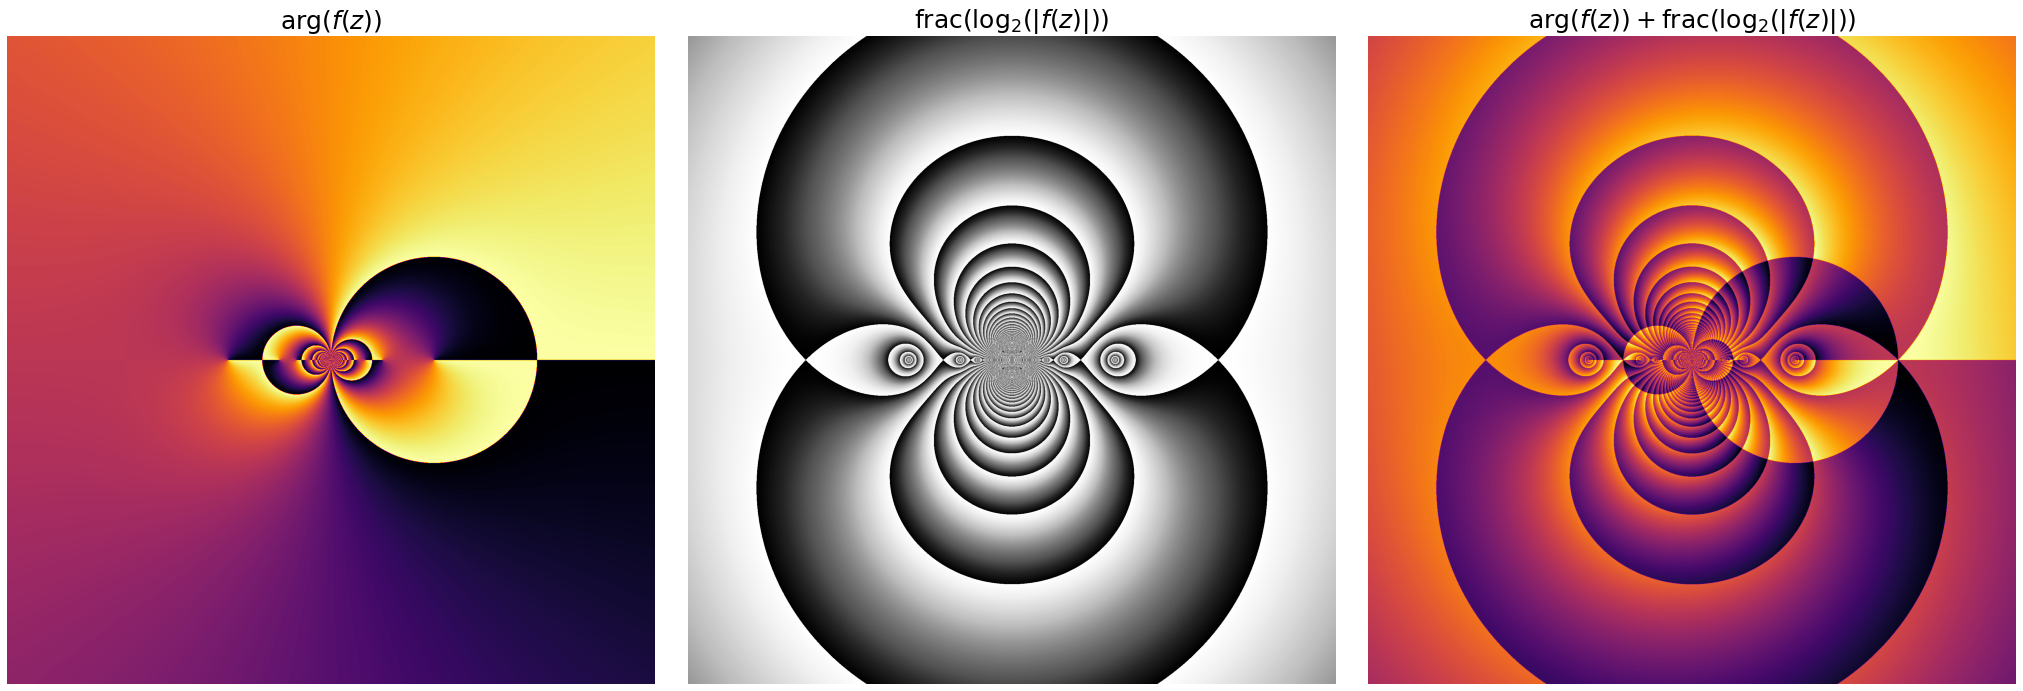

In [54]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*12,nrows*12))
fig.subplots_adjust(wspace=0.05)

ax = axes[0]
ax.imshow(arg, cmap=cmaps[2])
ax.set_title('$\mathrm{arg} \\left( f(z) \\right)$',
             fontsize=axistitlesize)

ax = axes[1]
ax.imshow(mask, cmap='Greys_r')
ax.set_title('$\mathrm{frac} \\left( \log_{2} (|f(z)|) \\right)$',
             fontsize=axistitlesize)

ax = axes[2]
ax.imshow(arg + mask, cmap=cmaps[2])
ax.set_title('$\mathrm{arg} \\left( f(z) \\right) + \mathrm{frac} \\left( \log_{2} (|f(z)|) \\right)$',
             fontsize=axistitlesize)

for ax in axes:
    ax.set_aspect('equal')
    ax.axis('off')

plt.show()

## Create gridlines

In [55]:
def create_grid(zz, thres):
    
    # Create base grid
    grid = np.zeros_like(zz).real
    for zz_c in [zz.real, zz.imag]:
        g = np.abs((np.abs(zz_c) % 1) - 0.5)
        g[g < thres] = 0
        g[g >= thres] = 1
        grid += g
    grid[grid == 2] = 1
    grid = np.abs(grid - 1)
    
    # Interpolate
    
    return grid

In [56]:
grid = create_grid(zz, thres=0.48)

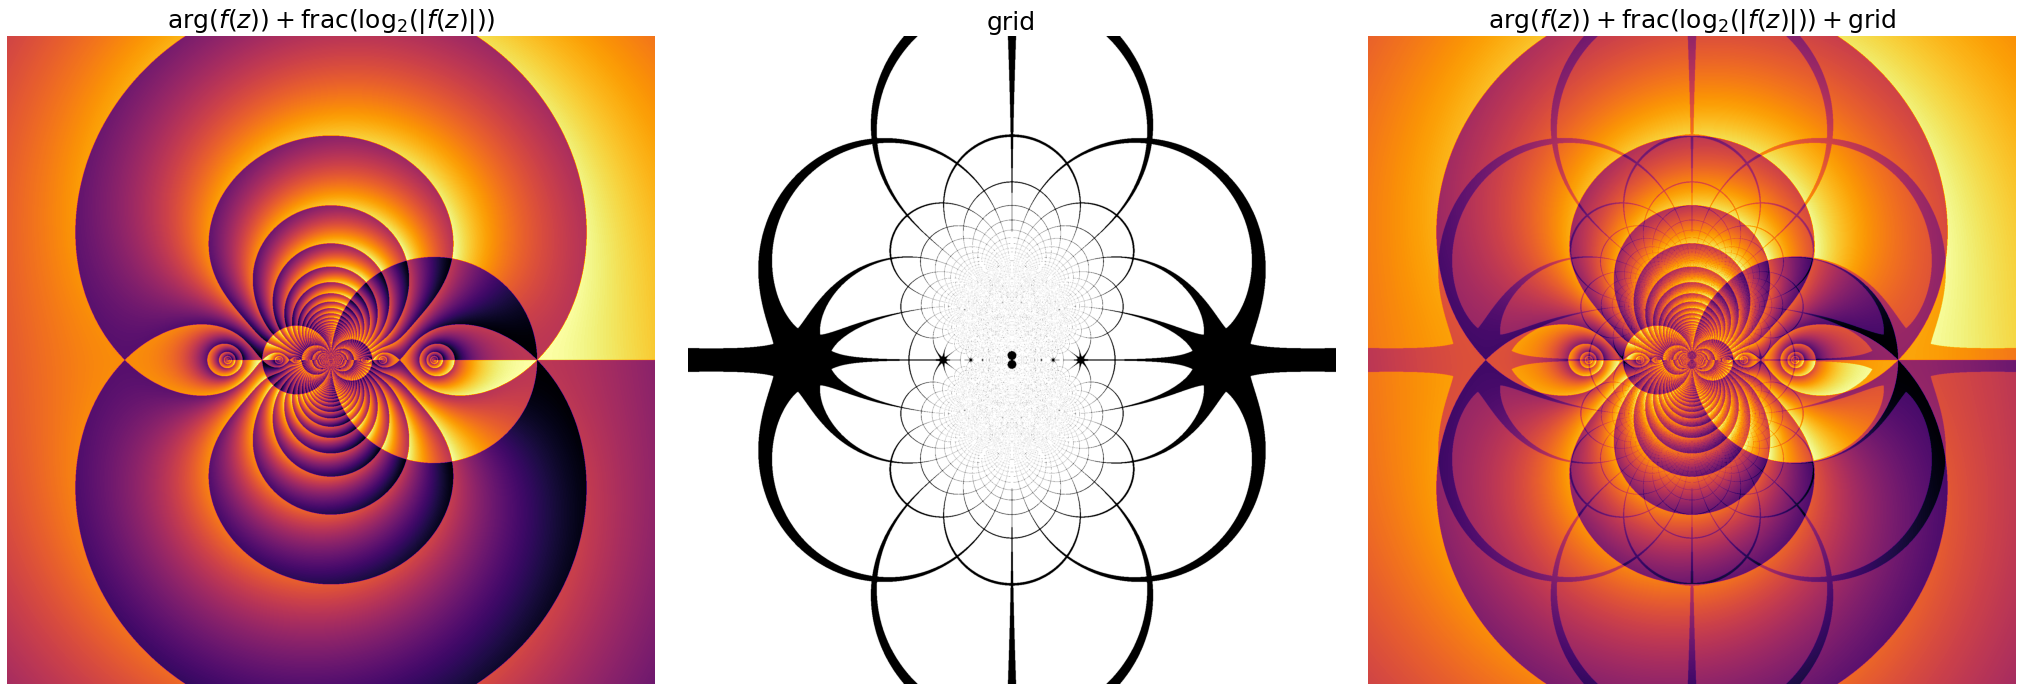

In [57]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*12,nrows*12))
fig.subplots_adjust(wspace=0.05)

ax = axes[0]
ax.imshow(arg + mask, cmap=cmaps[2])
ax.set_title('$\mathrm{arg} \\left( f(z) \\right) + \mathrm{frac} \\left( \log_{2} (|f(z)|) \\right)$',
             fontsize=axistitlesize)

ax = axes[1]
ax.imshow(grid, cmap='Greys_r', interpolation='bilinear')
ax.set_title('grid',
             fontsize=axistitlesize)

ax = axes[2]
ax.imshow(arg + mask + grid*0.5, cmap=cmaps[2])
#ax.imshow(grid, cmap='Greys_r', alpha=0.1)
ax.set_title('$\mathrm{arg} \\left( f(z) \\right) + \mathrm{frac} \\left( \log_{2} (|f(z)|) \\right) + \mathrm{grid}$',
             fontsize=axistitlesize)

for ax in axes:
    ax.set_aspect('equal')
    ax.axis('off')

plt.show()

## Final image with perceptually uniform colormaps

*Or more like perceptually uniform colormaps, which are implemented in `matplotlib`

In [42]:
def plot_collection(arg, mask, grid,
                    grid_alpha=0.5):
    plt.figure(figsize=(15*3,15*2),
               facecolor='ghostwhite')
    gs = gridspec.GridSpec(2, 6)
    gs.update(hspace=0.05, wspace=0.05)

    ax1 = plt.subplot(gs[0, :2])
    ax2 = plt.subplot(gs[0, 2:4])
    ax3 = plt.subplot(gs[0, 4:6])
    ax4 = plt.subplot(gs[1, 1:3])
    ax5 = plt.subplot(gs[1, 3:5])
    axes = [ax1, ax2, ax3, ax4, ax5]

    for i, cmap in enumerate(cmaps):
        axes[i].set_aspect('equal')
        axes[i].axis('off')

        im = axes[i].imshow(arg + mask + grid*grid_alpha, cmap=cmap)

    plt.show()

In [41]:
#plot_collection(arg=arg, mask=mask, grid=grid, grid_alpha=0.4)

## Domain coloring with `HSL` color model

(Currently thrash...)

In [127]:
def create_HSL_model(zz):
    """
    Create the HSV color model for the function domain that will be plotted.
    
    H, S, L parameters from here:
    https://en.wikipedia.org/wiki/Domain_coloring
    
    Converting HSL to RGB:
    https://en.wikipedia.org/wiki/HSL_and_HSV#HSL_to_RGB
    """
    # Create HSL model
    H = np.angle(zz)
    S = np.ones_like(H)
    L = 2 / np.pi * np.arctan(np.abs(zz))

    ## Convert it to RGB
    # 1. Calculate RGB parameters
    C = (1 - np.abs(2*L - 1)) * S       # Chroma
    H_ = np.rad2deg(H) / 60
    X = C * (1 - np.abs((H_ % 2) - 1))  # Some intermediate value
    m = L - C/2                         # Some color equalization
    zero = np.zeros_like(H_)
    
    # 2. Calculate RGB values
    R = np.zeros_like(H_)
    G = np.zeros_like(H_)
    B = np.zeros_like(H_)
    
    # Here
    #   - 0: C
    #   - 1: X
    #   - 2: zeros
    p = [C, X, zero]
    rgb_values = [
        [0, 1, 2],  # if 0 < H_ < 1
        [1, 0, 2],  # if 1 < H_ < 2
        [2, 0, 1],  # if 2 < H_ < 3
        [2, 1, 0],  # if 3 < H_ < 4
        [1, 2, 0],  # if 4 < H_ < 5
        [0, 2, 1],  # if 5 < H_ < 6
    ]
    for lim in range(0, 6):
        for rgb, val in zip([R,G,B], [p[r] for r in rgb_values[lim]]):
            mask = (lim <= H_) + (H_ < lim+1)
            rgb[mask] = val[mask]
    
    # 3. Create RGB table
    rgb = np.dstack((R+m,G+m,B+m))
    rgb[rgb < 0] = 0
    
    return rgb

In [132]:
# Create HSL map and convert it to RGB
rgb = create_HSL_model(zz=zz)

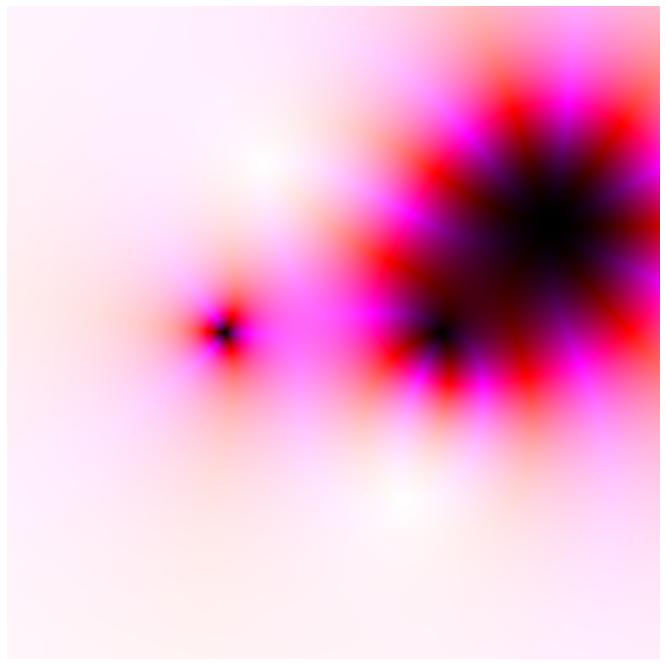

In [133]:
fig, axes = plt.subplots(figsize=(12,12))
axes.set_aspect('equal')
axes.axis('off')
axes.invert_yaxis()

axes.imshow(rgb)

plt.show()

## Domain coloring with `HSV` color model

(`HSV` values are not mine.)

In [58]:
def create_HSV_model(zz):
    """
    Create the HSV color model for the function domain that will be plotted
    
    H, S, V parameters from here:
    https://github.com/hernanat/dcolor/blob/master/dcolor.py
    """
    # Hue determined by arg(z)
    H = normalize(np.angle(zz) % (2 * np.pi))
    r = corr_singular(np.log2(1 + np.abs(zz)))
    S = (1 + np.abs(np.sin(2 * np.pi * r))) / 2
    V = (1 + np.abs(np.cos(2 * np.pi * r))) / 2

    return H,S,V

In [59]:
# Create HSV model
H,S,V = create_HSV_model(zz)
# Convert to RGB
rgb = hsv_to_rgb(np.dstack((H,S,V)))

<ipython-input-58-3f66f04c1e26>:10: RuntimeWarning: overflow encountered in absolute
  r = corr_singular(np.log2(1 + np.abs(zz)))
<ipython-input-58-3f66f04c1e26>:11: RuntimeWarning: overflow encountered in multiply
  S = (1 + np.abs(np.sin(2 * np.pi * r))) / 2
<ipython-input-58-3f66f04c1e26>:11: RuntimeWarning: invalid value encountered in sin
  S = (1 + np.abs(np.sin(2 * np.pi * r))) / 2
<ipython-input-58-3f66f04c1e26>:12: RuntimeWarning: overflow encountered in multiply
  V = (1 + np.abs(np.cos(2 * np.pi * r))) / 2
<ipython-input-58-3f66f04c1e26>:12: RuntimeWarning: invalid value encountered in cos
  V = (1 + np.abs(np.cos(2 * np.pi * r))) / 2


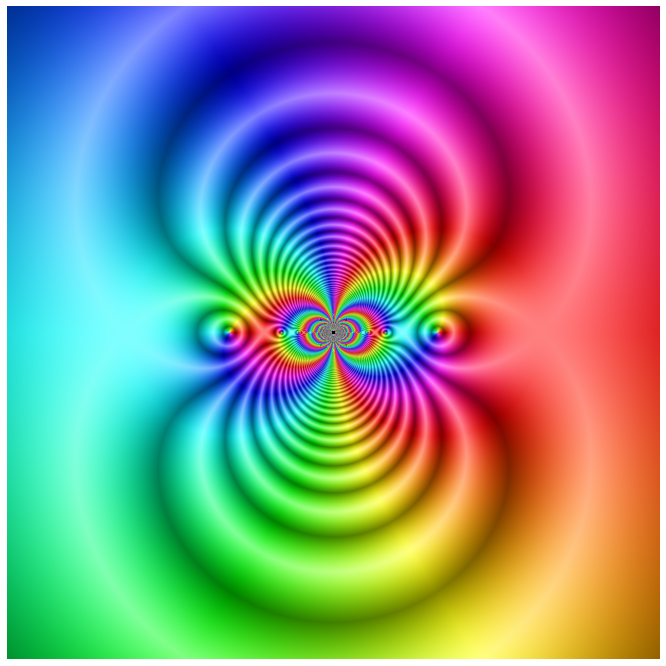

In [60]:
fig, axes = plt.subplots(figsize=(12,12))
axes.set_aspect('equal')
axes.axis('off')
axes.invert_yaxis()

axes.imshow(rgb)

plt.show()

## Julia sets

In [139]:
def f(zz, c):
    
    return  zz**2 + c

In [38]:
def iterate(zz, c, N=5):

    zz = f(zz, c)
    
    if N > 1:
        return iterate(zz, c, N-1)
    else:
        return zz

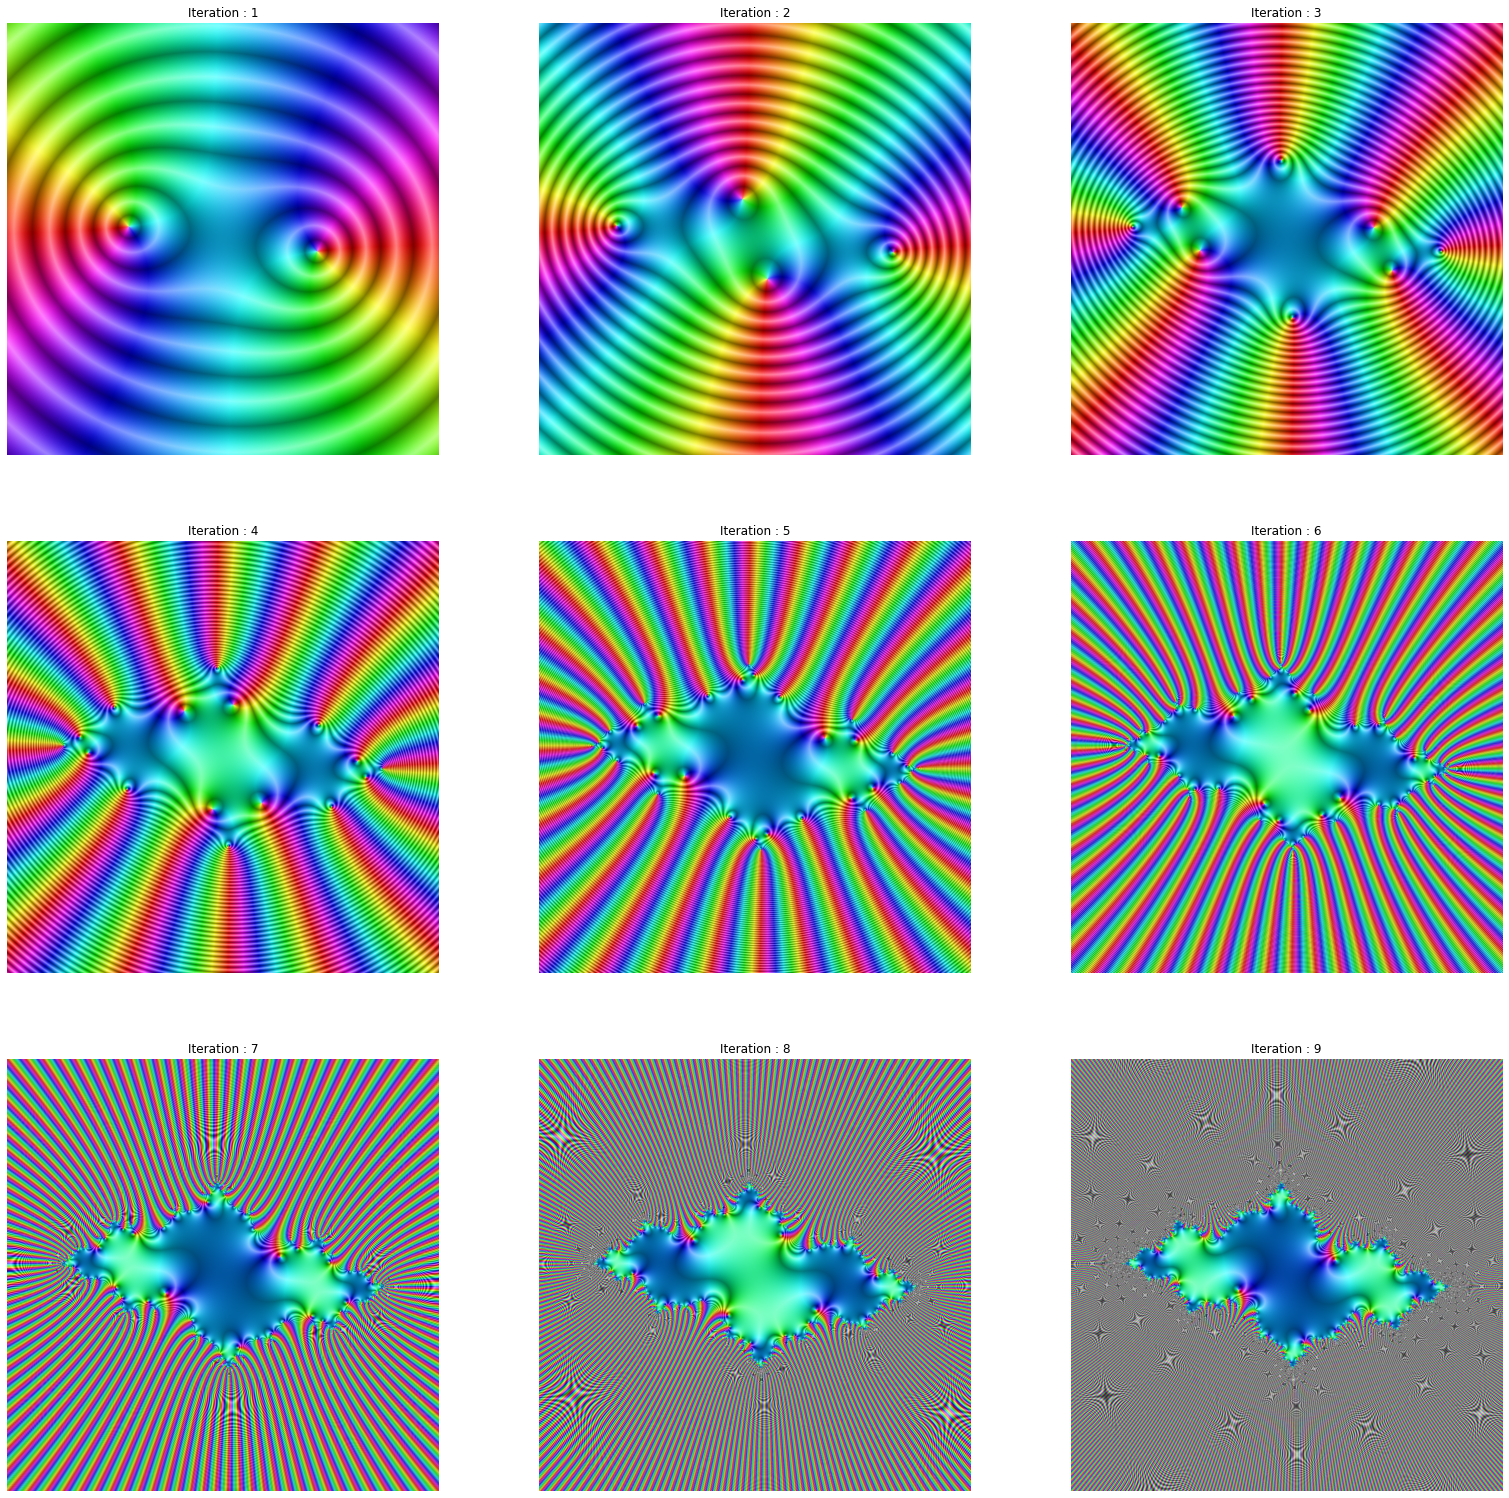

In [39]:
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*9,nrows*9))

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i,j]
        ax.set_aspect('equal')
        ax.axis('off')
        ax.invert_yaxis()

        it = (i*ncols + j) + 1
        zz = create_domain(xy=2, N=1000)
        zz = iterate(zz, c=(-0.75 - 0.2j), N=it)
        H,S,V = create_color_model_2(zz)
        rgb = hsv_to_rgb(np.dstack((H,S,V)))
        
        ax.set_title('Iteration : {0}'.format(it))
        
        ax.imshow(rgb)

plt.show()